<a href="https://colab.research.google.com/github/johnjquinn/OCR/blob/main/HW4_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#HW4 OCR Report
John Quinn  
Imaging and Multimedia  
2 December 2022

##Initial Testing

Within the initial testing phase, I used a global binary threshold of 235 as I believed that it provided sufficient enough to dilineate the characters for all training images.

###Setup of Code

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage import io, exposure
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle

FeatureData = []
LabelData = []
Means = []
Stds = []
pkl_file = open('test_gt_py3.pkl', 'rb')
mydict = pickle.load(pkl_file)
pkl_file.close()
classes = mydict[b'classes']
locations = mydict[b'locations']
th = 235
Chars = ['a', 'd', 'm', 'n', 'o', 'p', 'q', 'r', 'u', 'w']

###Groundtruth Center Detection
This function receives a set of bounding box coordinates, and returns the index of the corresponding groundtruth center which is contained in said box. If no center is detected, then an error value of -1 is returned

In [ ]:
def contains_groundtruth(minr, maxr, minc, maxc):
    global locations
    for i in range(len(locations)):
        loc = locations[i]
        if(loc[0] >= minc and loc[0] <= maxc and loc[1] >= minr and loc[1] <= maxr): return i
    return -1

###Training Code

In [ ]:
def train(debug=False):
    global FeatureData
    global LabelData
    global Means
    global Stds
    total_boxes = []
    # The elements of this array contain all of the
    # bounding box corrdinates for each letter component

    for char in Chars:

        # each char training image is opened, binarized, and labeled
        char_img = io.imread(f'{char}.bmp')
        char_bin = (char_img<th).astype(np.double)
        char_lbl = label(char_bin, background=0)

        # components are extracted
        regions = regionprops(char_lbl)
        letter_boxes = []
        for props in regions:
            # each bounding box is identified
            minr, minc, maxr, maxc = props.bbox
            reg_width = maxc-minc
            reg_height = maxr-minr
            # if the detected box has either width or height underneath
            # the size threshold of 10 pixels, it is ignored
            if(reg_width<=10 or reg_height<=10): continue
            # the box is above the threshold and its region is ready
            # to be processed
            letter_boxes.append([minc, maxc, minr, maxr])
            roi = char_bin[minr:maxr, minc:maxc]
            # computing the hu moments for this region
            m = moments(roi)
            cc = m[0,1] / m[0,0]
            cr = m[1,0] / m[0,0]
            mu = moments_central(roi, center=(cr, cc))
            nu = moments_normalized(mu)
            hu = moments_hu(nu)
            # adding hu moments and associated label data
            # their respective arrays
            FeatureData.append(hu)
            LabelData.append(char if char != 'u' else 'U')
        # each extracted box coordinates are added to the total
        total_boxes.append(letter_boxes)
    # feature data is being normalized
    Means = np.mean(FeatureData, axis=0)
    Stds = np.std(FeatureData, axis=0)
    for feature in FeatureData:
        for i in range(7):
            feature[i] = (feature[i]-Means[i])/Stds[i]
    # Distance Matrix computed and sorted
    DistMatrix = cdist(FeatureData, FeatureData)
    D_index = np.argsort(DistMatrix, axis=1)
    Ytrue = []
    Ypred = []
    for i in range(len(FeatureData)):
        Ytrue.append(LabelData[i])
        Ypred.append(LabelData[D_index[i][1]])
    confM = confusion_matrix(Ytrue, Ypred)
    # Confusion Matrix computed

    if(debug is True):
    # generating recognition images
        running = 0
        for i in range(len(Chars)):
            # regenerates label images
            curr_char = Chars[i]
            char_img = io.imread(f'{curr_char}.bmp')
            char_bin = (char_img<th).astype(np.double)
            char_lbl = label(char_bin, background=0)
            # retrieves box coordinates
            letter_boxes = total_boxes[i]
            plt.imshow(char_bin)
            ax = plt.gca()
            for j in range(len(letter_boxes)):
                minc = letter_boxes[j][0]
                maxc = letter_boxes[j][1]
                minr = letter_boxes[j][2]
                maxr = letter_boxes[j][3]
                # adds rectangles based on box corrdinates
                ax.add_patch(Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, edgecolor='red', linewidth=1))
                # adds recognized letter to image
                ax.text(maxc+1, minr+1, Ypred[running+j], color='white')
            running += len(letter_boxes)
            ax.set_title('Bounding Boxes and Recognition Result')
            io.show()

    # displaying distance and confusion matrices
    io.imshow(DistMatrix)
    plt.title('Distance Matrix')
    io.show()
    io.imshow(confM)
    plt.title('Confusion Matrix')
    io.show()

###Recognition Code

In [ ]:
def test(path, debug=False):
    train(debug)
    global FeatureData
    global LabelData
    global Means
    global Stds
    global classes

    # processes image in the same way as in the training data
    img = io.imread(path)
    img_bin = (img<th).astype(np.double)
    img_lbl = label(img_bin, background=0)
    total_components = np.amax(img_lbl)
    regions = regionprops(img_lbl)
    groundtruth_labels = []
    test_features = []
    test_labels = []
    letter_boxes = []
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        reg_width = maxc-minc
        reg_height = maxr-minr
        if(reg_width<=10 or reg_height<=10): continue
        # calls groundtruth detection code
        gt_index = contains_groundtruth(minr, maxr, minc, maxc)
        if(gt_index == -1): continue
        else: groundtruth_labels.append(classes[gt_index])
        # if index was found, groundtruth label is retrieved and logged
        letter_boxes.append([minc, maxc, minr, maxr])
        roi = img_bin[minr:maxr, minc:maxc]
        m = moments(roi)
        cc = m[0,1] / m[0,0]
        cr = m[1,0] / m[0,0]
        mu = moments_central(roi, center=(cr, cc))
        nu = moments_normalized(mu)
        hu = moments_hu(nu)
        test_features.append(hu)
    # new features are normalized
    for feature in test_features:
        for i in range(7):
            feature[i] = (feature[i]-Means[i])/Stds[i]
    # new distance matrix computed and used for recognition
    TestDistance = cdist(test_features, FeatureData)
    TD_index = np.argsort(TestDistance, axis=1)
    hits = 0
    misses = 0
    for i in range(len(test_features)):
        test_labels.append(LabelData[TD_index[i][0]])
        # detects recognition hits and misses
        if(test_labels[i] == groundtruth_labels[i]): hits += 1
        else: misses += 1
    # recognition rate computed here
    hitRate = 100*hits/len(test_labels)
    print(f'Recognition Rate: {hitRate}%')
    # total components, including those excluded from analysis
    # are counted
    print(f'Total Components for Test: {total_components}')
    plt.imshow(img_lbl)
    ax = plt.gca()
    # recognition image generated
    for i in range(len(letter_boxes)):
        minc = letter_boxes[i][0]
        maxc = letter_boxes[i][1]
        minr = letter_boxes[i][2]
        maxr = letter_boxes[i][3]
        ax.add_patch(Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, edgecolor='red', linewidth=1))
        ax.text(maxc+1, minr+1, test_labels[i], color='white')
    ax.set_title('Bounding Boxes and Recognition Result')
    io.show()

###Initial Results
Using the code listed above as is yielded a recognition rate of 51.43%, with 72 total components detected in the image

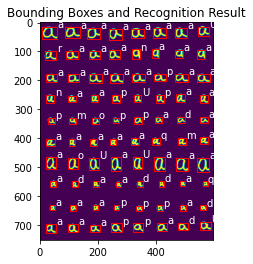

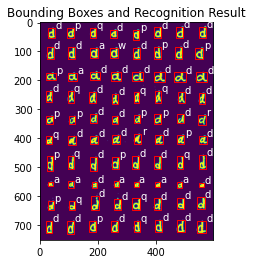

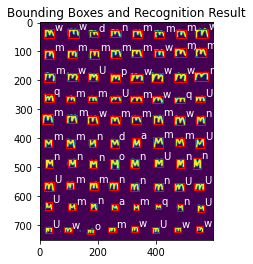

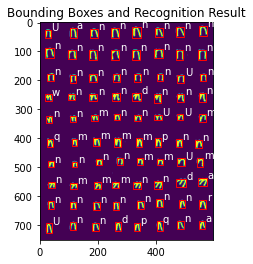

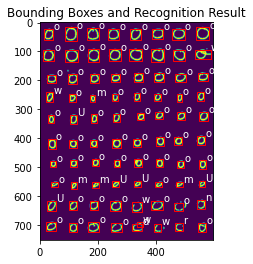

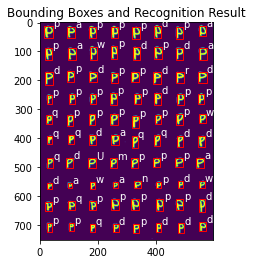

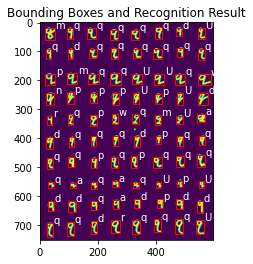

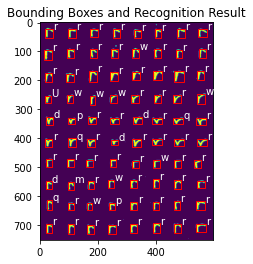

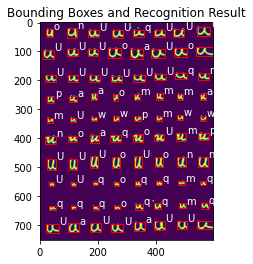

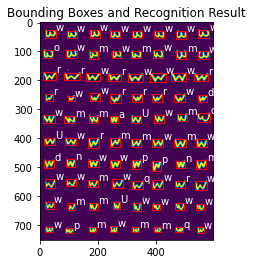

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


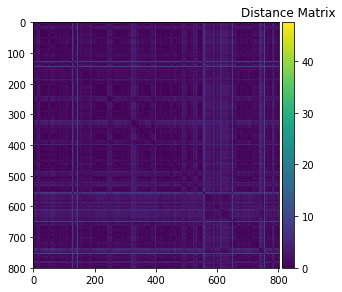

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


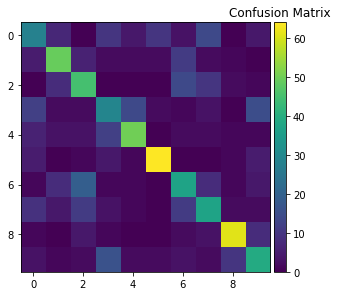

Recognition Rate: 51.42857142857143%
Total Components for Test: 72


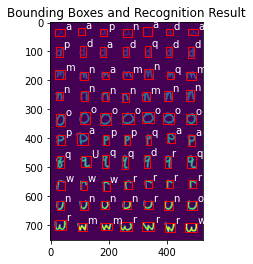

In [ ]:
test('test.bmp', debug=True)

##Enhancements

###Potential issues

From the initial run of testing, I had noticed a lot of discrepancies within the detected components. As shown in both the connected component image from the training images and the confusion matrix, letters were frequently confused with each other. The confusion matrix shows the letter p as being the one being correctly identified the most, with u being not far off. Despite this, within the test image, the letter o had been correctly identified completely, and the letter u wasn't properly detected at all.

Another thing of note is the detection of a secondary edge component within the label image for "o.bmp", which had erroneously detected two letters within the span of one at the bottom of the image.

These issues could potentially be caused by improper thresholding, insufficient noise removal, or by insufficient letter classification. Within the next few sections, I will attempt to redress each of these potential causes, and see which attempts yield the best improvements to the rate of recognition.

###Thresholding

The initial threshold value of 235 was chosen in a rather arbitrary manner, as too low of a value would break up edge components, and too high of a value would increase noise dramatically.

Shown Below are a section of other arbitrary threshold values, and how they correlate to final recognition rates.

####Arbitrary Thresholds
These trials were done using arbitrary threshold values

#####Trials

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


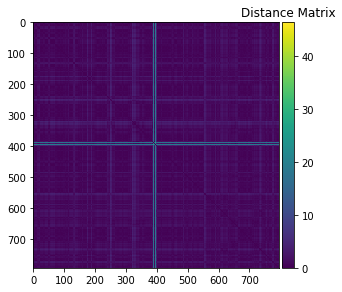

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


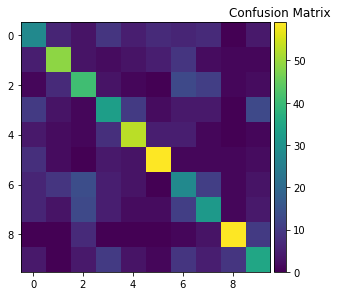

Recognition Rate: 54.285714285714285%
Total Components for Test: 80


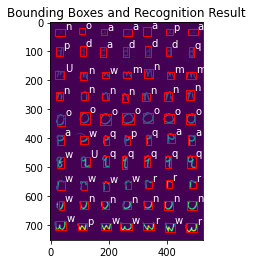

In [ ]:
th = 200
test('test.bmp')

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


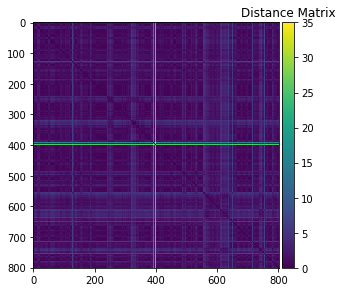

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


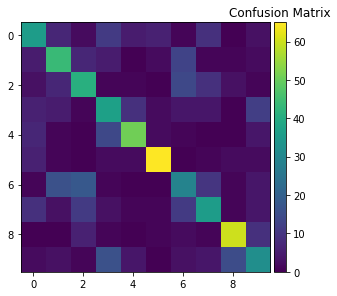

Recognition Rate: 51.42857142857143%
Total Components for Test: 71


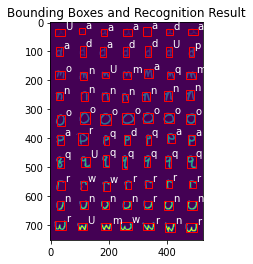

In [ ]:
th = 215
test('test.bmp')

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


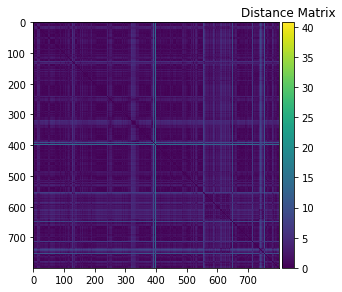

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


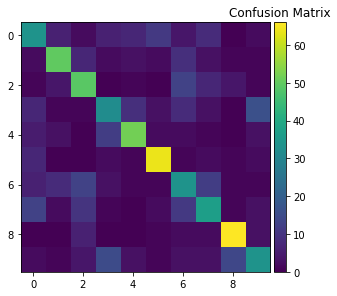

Recognition Rate: 52.857142857142854%
Total Components for Test: 72


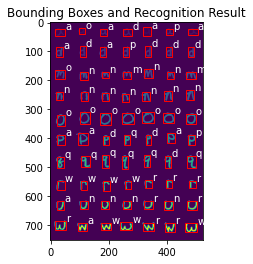

In [ ]:
th = 220
test('test.bmp')

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


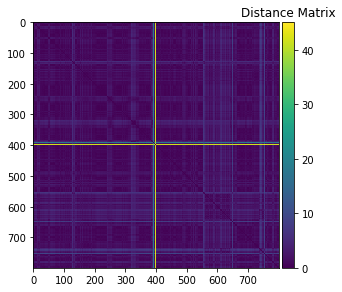

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


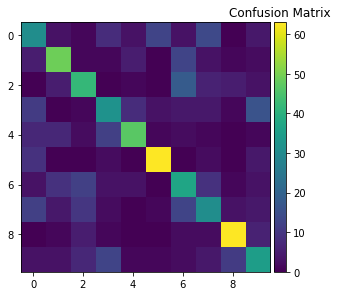

Recognition Rate: 41.42857142857143%
Total Components for Test: 72


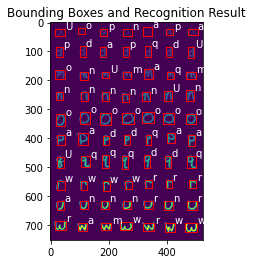

In [ ]:
th = 225
test('test.bmp')

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


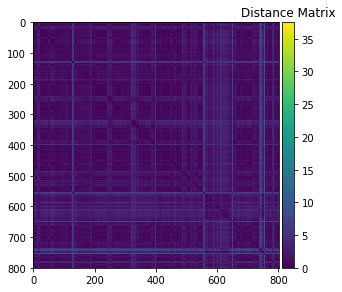

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


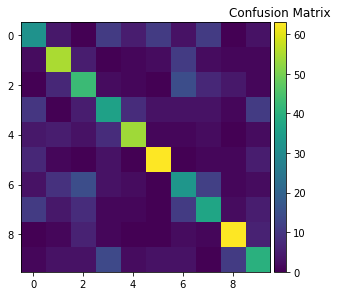

Recognition Rate: 47.142857142857146%
Total Components for Test: 71


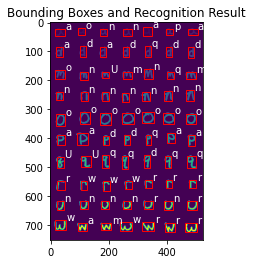

In [ ]:
th = 230
test('test.bmp')

#####Results

* Threshold 200 => 54.29%
* Threshold 215 => 51.43%
* Threshold 220 => 52.86%
* Threshold 225 => 41.43%
* Threshold 230 => 47.14%
* Threshold 235 => 51.43%

The recognition rate varied considerably from one threshold value to the next, with the highest appearing to be at a value of 200. With these values arbitrarily changing, perhaps an automated selection of a threshold would optimize further.

####Automated Thresholding

This function utilizes the ptile method of finding an image threshold, first by computing the individual thresholds for each image, and then returning the average of all of them

In [ ]:
def auto_threshold(ptile):
    global Chars
    threshs = 0
    for char in Chars:
        char_img = io.imread(f'{char}.bmp')
        char_w, char_h = char_img.shape
        char_hist = exposure.histogram(char_img)
        pix = 0
        tick = 0
        for i in range(256):
            if (pix < ptile*char_w*char_h) :
                pix += char_hist[0][i]
                tick += 1
            else: break
        if(pix<char_w*char_h): threshs += tick
        else: return -1
    return np.floor(threshs/len(Chars))

#####Trials

248.0


/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


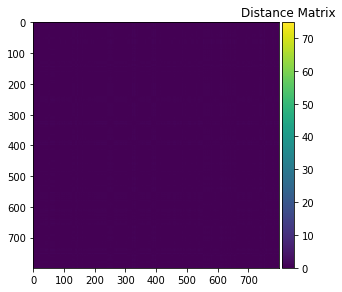

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


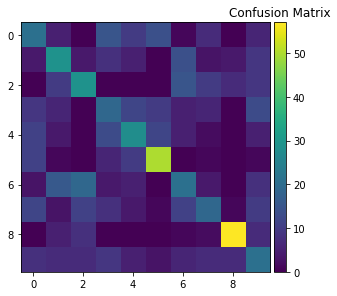

Recognition Rate: 40.0%
Total Components for Test: 73


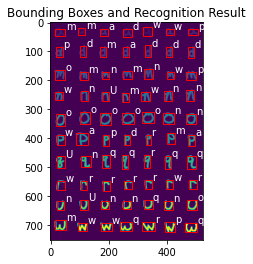

In [ ]:
th = auto_threshold(0.1)
print(th)
test('test.bmp')

195.0


/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


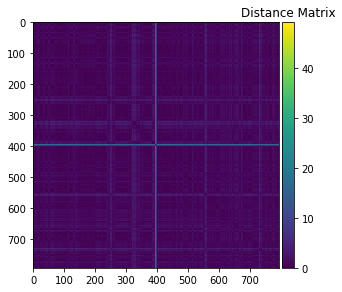

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


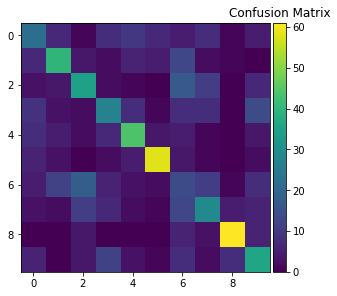

Recognition Rate: 50.0%
Total Components for Test: 77


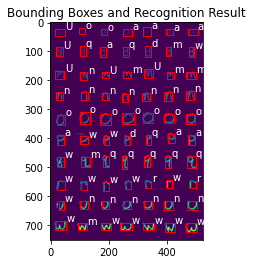

In [ ]:
th = auto_threshold(0.05)
print(th)
test('test.bmp')

232.0


/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


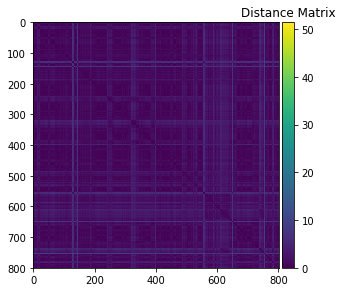

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


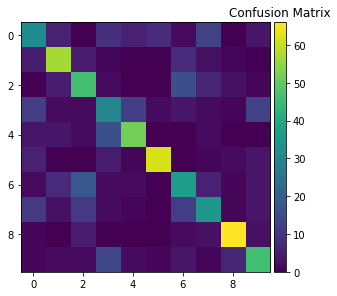

Recognition Rate: 47.142857142857146%
Total Components for Test: 71


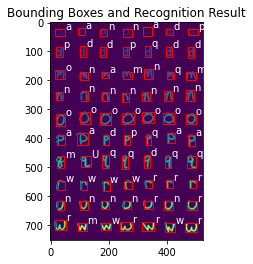

In [ ]:
th = auto_threshold(0.075)
print(th)
test('test.bmp')

218.0


/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


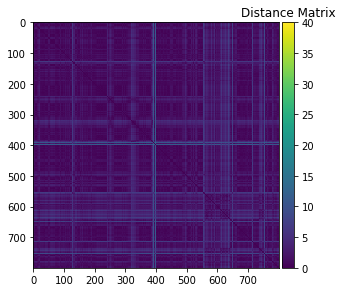

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


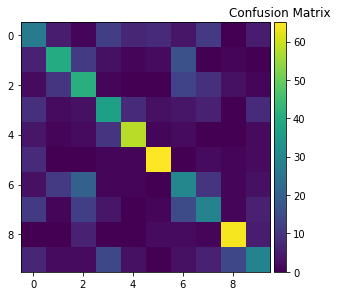

Recognition Rate: 47.142857142857146%
Total Components for Test: 71


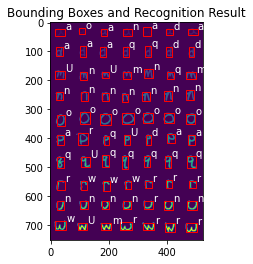

In [ ]:
th = auto_threshold(0.0625)
print(th)
test('test.bmp')

207.0


/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


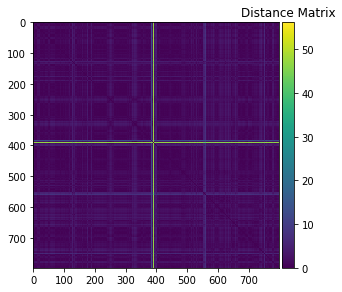

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


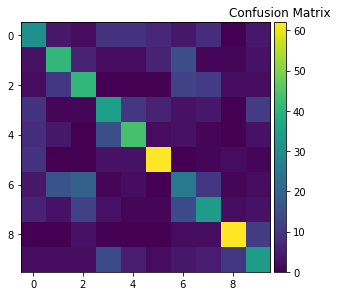

Recognition Rate: 45.714285714285715%
Total Components for Test: 77


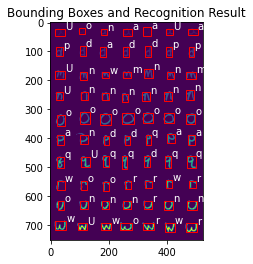

In [ ]:
th = auto_threshold(0.05625)
print(th)
test('test.bmp')

#####Results

Using the automated threshold method defined above, the highest recognition rate I achieved was 50% with a p-tile of 0.05. This was lower than the original rate of 51%. The biggest enhancement I was able to achieve was at a threshold of 200, with the rate improving by 5.56%.

This likely suggests that proper thresholding isn't the only issue. My next approach at enhancement will be using binary morphology to try and minimize image noise.

###Noise Reduction

Here, I will be utilizing scikit-image's morphology module in order to use its binary open and close operations. I have made the following modifications to the import and training functions in order to utilize the morphological open and close.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage import io, exposure, morphology
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle

FeatureData = []
LabelData = []
Means = []
Stds = []
pkl_file = open('test_gt_py3.pkl', 'rb')
mydict = pickle.load(pkl_file)
pkl_file.close()
classes = mydict[b'classes']
locations = mydict[b'locations']
th = 235
Chars = ['a', 'd', 'm', 'n', 'o', 'p', 'q', 'r', 'u', 'w']

In [ ]:
def train(debug=False):
    global FeatureData
    global LabelData
    global Means
    global Stds
    total_boxes = []
    # The elements of this array contain all of the
    # bounding box corrdinates for each letter component

    for char in Chars:

        # each char training image is opened, binarized, and labeled
        char_img = io.imread(f'{char}.bmp')
        char_bin = (char_img<th).astype(np.double)
        char_close = morphology.area_closing(char_bin)
        char_lbl = label(char_close, background=0)

        # components are extracted
        regions = regionprops(char_lbl)
        letter_boxes = []
        for props in regions:
            # each bounding box is identified
            minr, minc, maxr, maxc = props.bbox
            reg_width = maxc-minc
            reg_height = maxr-minr
            # if the detected box has either width or height underneath
            # the size threshold of 10 pixels, it is ignored
            #if(reg_width<=10 or reg_height<=10): continue
            # the box is above the threshold and its region is ready
            # to be processed
            letter_boxes.append([minc, maxc, minr, maxr])
            roi = char_bin[minr:maxr, minc:maxc]
            # computing the hu moments for this region
            m = moments(roi)
            cc = m[0,1] / m[0,0]
            cr = m[1,0] / m[0,0]
            mu = moments_central(roi, center=(cr, cc))
            nu = moments_normalized(mu)
            hu = moments_hu(nu)
            # adding hu moments and associated label data
            # their respective arrays
            FeatureData.append(hu)
            LabelData.append(char if char != 'u' else 'U')
        # each extracted box coordinates are added to the total
        total_boxes.append(letter_boxes)
    # feature data is being normalized
    Means = np.mean(FeatureData, axis=0)
    Stds = np.std(FeatureData, axis=0)
    for feature in FeatureData:
        for i in range(7):
            feature[i] = (feature[i]-Means[i])/Stds[i]
    # Distance Matrix computed and sorted
    DistMatrix = cdist(FeatureData, FeatureData)
    D_index = np.argsort(DistMatrix, axis=1)
    Ytrue = []
    Ypred = []
    for i in range(len(FeatureData)):
        Ytrue.append(LabelData[i])
        Ypred.append(LabelData[D_index[i][1]])
    confM = confusion_matrix(Ytrue, Ypred)
    # Confusion Matrix computed

    if(debug is True):
    # generating recognition images
        running = 0
        for i in range(len(Chars)):
            # regenerates label images
            curr_char = Chars[i]
            char_img = io.imread(f'{curr_char}.bmp')
            char_bin = (char_img<th).astype(np.double)
            char_lbl = label(char_bin, background=0)
            # retrieves box coordinates
            letter_boxes = total_boxes[i]
            plt.imshow(char_bin)
            ax = plt.gca()
            for j in range(len(letter_boxes)):
                minc = letter_boxes[j][0]
                maxc = letter_boxes[j][1]
                minr = letter_boxes[j][2]
                maxr = letter_boxes[j][3]
                # adds rectangles based on box corrdinates
                ax.add_patch(Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, edgecolor='red', linewidth=1))
                # adds recognized letter to image
                ax.text(maxc+1, minr+1, Ypred[running+j], color='white')
            running += len(letter_boxes)
            ax.set_title('Bounding Boxes and Recognition Result')
            io.show()

    # displaying distance and confusion matrices
    io.imshow(DistMatrix)
    plt.title('Distance Matrix')
    io.show()
    io.imshow(confM)
    plt.title('Confusion Matrix')
    io.show()

####Using high threshold with close
This first test uses a threshold of 235 and a binary close

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


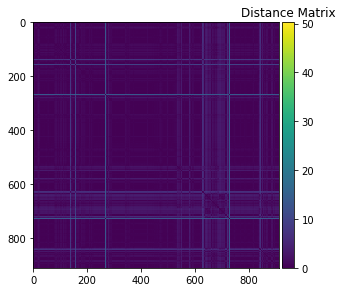

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


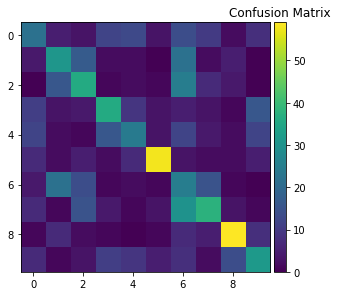

Recognition Rate: 38.57142857142857%
Total Components for Test: 72


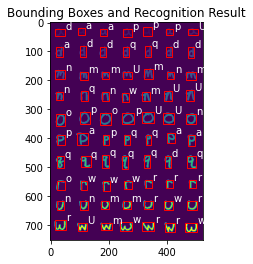

In [ ]:
test('test.bmp')

As shown above, this approach had a disappointing yield, with the recognition rate taking a dive, coming out to 38.57%.

####Using low threshold with open
The training code is modified again, this time to use a threshold of 200 with a binary open.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage import io, exposure, morphology
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle

FeatureData = []
LabelData = []
Means = []
Stds = []
pkl_file = open('test_gt_py3.pkl', 'rb')
mydict = pickle.load(pkl_file)
pkl_file.close()
classes = mydict[b'classes']
locations = mydict[b'locations']
th = 200
Chars = ['a', 'd', 'm', 'n', 'o', 'p', 'q', 'r', 'u', 'w']

In [ ]:
def train(debug=False):
    global FeatureData
    global LabelData
    global Means
    global Stds
    total_boxes = []
    # The elements of this array contain all of the
    # bounding box corrdinates for each letter component

    for char in Chars:

        # each char training image is opened, binarized, and labeled
        char_img = io.imread(f'{char}.bmp')
        char_bin = (char_img<th).astype(np.double)
        char_open = morphology.area_opening(char_bin)
        char_lbl = label(char_open, background=0)

        # components are extracted
        regions = regionprops(char_lbl)
        letter_boxes = []
        for props in regions:
            # each bounding box is identified
            minr, minc, maxr, maxc = props.bbox
            reg_width = maxc-minc
            reg_height = maxr-minr
            # if the detected box has either width or height underneath
            # the size threshold of 10 pixels, it is ignored
            #if(reg_width<=10 or reg_height<=10): continue
            # the box is above the threshold and its region is ready
            # to be processed
            letter_boxes.append([minc, maxc, minr, maxr])
            roi = char_bin[minr:maxr, minc:maxc]
            # computing the hu moments for this region
            m = moments(roi)
            cc = m[0,1] / m[0,0]
            cr = m[1,0] / m[0,0]
            mu = moments_central(roi, center=(cr, cc))
            nu = moments_normalized(mu)
            hu = moments_hu(nu)
            # adding hu moments and associated label data
            # their respective arrays
            FeatureData.append(hu)
            LabelData.append(char if char != 'u' else 'U')
        # each extracted box coordinates are added to the total
        total_boxes.append(letter_boxes)
    # feature data is being normalized
    Means = np.mean(FeatureData, axis=0)
    Stds = np.std(FeatureData, axis=0)
    for feature in FeatureData:
        for i in range(7):
            feature[i] = (feature[i]-Means[i])/Stds[i]
    # Distance Matrix computed and sorted
    DistMatrix = cdist(FeatureData, FeatureData)
    D_index = np.argsort(DistMatrix, axis=1)
    Ytrue = []
    Ypred = []
    for i in range(len(FeatureData)):
        Ytrue.append(LabelData[i])
        Ypred.append(LabelData[D_index[i][1]])
    confM = confusion_matrix(Ytrue, Ypred)
    # Confusion Matrix computed

    if(debug is True):
    # generating recognition images
        running = 0
        for i in range(len(Chars)):
            # regenerates label images
            curr_char = Chars[i]
            char_img = io.imread(f'{curr_char}.bmp')
            char_bin = (char_img<th).astype(np.double)
            char_lbl = label(char_bin, background=0)
            # retrieves box coordinates
            letter_boxes = total_boxes[i]
            plt.imshow(char_bin)
            ax = plt.gca()
            for j in range(len(letter_boxes)):
                minc = letter_boxes[j][0]
                maxc = letter_boxes[j][1]
                minr = letter_boxes[j][2]
                maxr = letter_boxes[j][3]
                # adds rectangles based on box corrdinates
                ax.add_patch(Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, edgecolor='red', linewidth=1))
                # adds recognized letter to image
                ax.text(maxc+1, minr+1, Ypred[running+j], color='white')
            running += len(letter_boxes)
            ax.set_title('Bounding Boxes and Recognition Result')
            io.show()

    # displaying distance and confusion matrices
    io.imshow(DistMatrix)
    plt.title('Distance Matrix')
    io.show()
    io.imshow(confM)
    plt.title('Confusion Matrix')
    io.show()

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


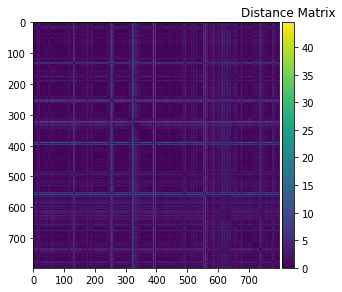

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


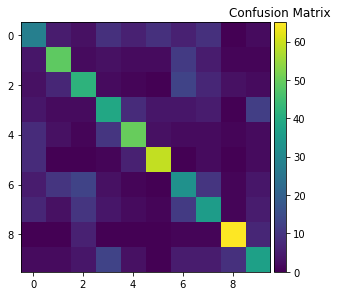

Recognition Rate: 52.857142857142854%
Total Components for Test: 80


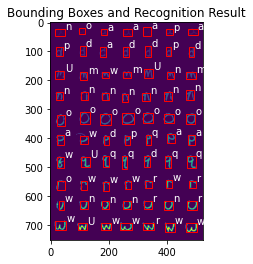

In [ ]:
test('test.bmp')

####Results

While the low threshold and open did provide a boost to the rate, it was still lower than the gain provided by the original region filer, with an increase of only 2.78% compared to the boost of 5.56% achieved earlier. This may suggest that the core underlying issue may not be with the original image processing, but with how the final recognition is performed. With these last tests, the threshold will remain at 235 and have the original region filter intact.

###Distance Matrix Sorting

To realize the potential of using different neighbor methods, I wrote a method that takes in the row of the sorted distance matrix, a number of neighbors, and a given offset to account for both training and testing.

In [ ]:
def neighbor_select(D_ind_row, num, offset):
    global Chars
    global LabelData
    letters = [] # 2d array with char and number
    appearances = []
    for i in range(offset, offset+num):
        in_letter = LabelData[D_ind_row[i]].lower()
        letters.append(in_letter)
    for char in Chars:
        freq = letters.count(char)
        appearances.append(freq)
    ind = np.argmax(appearances)
    if(isinstance(ind, list)): ind = ind[0]
    return Chars[ind]


####Modification to Training Code

In [ ]:
def train(debug=False):
    global FeatureData
    global LabelData
    global Means
    global Stds
    total_boxes = []
    # The elements of this array contain all of the
    # bounding box corrdinates for each letter component
    for char in Chars:

        # each char training image is opened, binarized, and labeled
        char_img = io.imread(f'{char}.bmp')
        char_bin = (char_img<th).astype(np.double)
        char_lbl = label(char_bin, background=0)
        # components are extracted
        regions = regionprops(char_lbl)
        letter_boxes = []
        for props in regions:
            # each bounding box is identified
            minr, minc, maxr, maxc = props.bbox
            reg_width = maxc-minc
            reg_height = maxr-minr
            # if the detected box has either width or height underneath
            # the size threshold of 10 pixels, it is ignored
            if(reg_width<=10 or reg_height<=10): continue
            # the box is above the threshold and its region is ready
            # to be processed
            letter_boxes.append([minc, maxc, minr, maxr])
            roi = char_bin[minr:maxr, minc:maxc]
            # computing the hu moments for this region
            m = moments(roi)
            cc = m[0,1] / m[0,0]
            cr = m[1,0] / m[0,0]
            mu = moments_central(roi, center=(cr, cc))
            nu = moments_normalized(mu)
            hu = moments_hu(nu)
            # adding hu moments and associated label data
            # their respective arrays
            FeatureData.append(hu)
            LabelData.append(char if char != 'u' else 'U')
        # each extracted box coordinates are added to the total
        total_boxes.append(letter_boxes)
    # feature data is being normalized
    Means = np.mean(FeatureData, axis=0)
    Stds = np.std(FeatureData, axis=0)
    for feature in FeatureData:
        for i in range(7):
            feature[i] = (feature[i]-Means[i])/Stds[i]
    # Distance Matrix computed and sorted
    DistMatrix = cdist(FeatureData, FeatureData)
    D_index = np.argsort(DistMatrix, axis=1)
    Ytrue = []
    Ypred = []
    for i in range(len(FeatureData)):
        Ytrue.append(LabelData[i])
        Ypred.append(neighbor_select(D_index[i], 11, 1))
    confM = confusion_matrix(Ytrue, Ypred)
    # Confusion Matrix computed

    if(debug is True):
    # generating recognition images
        running = 0
        for i in range(len(Chars)):
            # regenerates label images
            curr_char = Chars[i]
            char_img = io.imread(f'{curr_char}.bmp')
            char_bin = (char_img<th).astype(np.double)
            char_lbl = label(char_bin, background=0)
            # retrieves box coordinates
            letter_boxes = total_boxes[i]
            plt.imshow(char_bin)
            ax = plt.gca()
            for j in range(len(letter_boxes)):
                minc = letter_boxes[j][0]
                maxc = letter_boxes[j][1]
                minr = letter_boxes[j][2]
                maxr = letter_boxes[j][3]
                # adds rectangles based on box corrdinates
                ax.add_patch(Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, edgecolor='red', linewidth=1))
                # adds recognized letter to image
                ax.text(maxc+1, minr+1, Ypred[running+j], color='white')
            running += len(letter_boxes)
            ax.set_title('Bounding Boxes and Recognition Result')
            io.show()

    # displaying distance and confusion matrices
    io.imshow(DistMatrix)
    plt.title('Distance Matrix')
    io.show()
    io.imshow(confM)
    plt.title('Confusion Matrix')
    io.show()

####Modification to Testing Code

In [ ]:
def test(path, debug=False):
    train(debug)
    global FeatureData
    global LabelData
    global Means
    global Stds
    global classes

    # processes image in the same way as in the training data
    img = io.imread(path)
    img_bin = (img<th).astype(np.double)
    img_lbl = label(img_bin, background=0)
    total_components = np.amax(img_lbl)
    regions = regionprops(img_lbl)
    groundtruth_labels = []
    test_features = []
    test_labels = []
    letter_boxes = []
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        reg_width = maxc-minc
        reg_height = maxr-minr
        if(reg_width<=10 or reg_height<=10): continue
        # calls groundtruth detection code
        gt_index = contains_groundtruth(minr, maxr, minc, maxc)
        if(gt_index == -1): continue
        else: groundtruth_labels.append(classes[gt_index])
        # if index was found, groundtruth label is retrieved and logged
        letter_boxes.append([minc, maxc, minr, maxr])
        roi = img_bin[minr:maxr, minc:maxc]
        m = moments(roi)
        cc = m[0,1] / m[0,0]
        cr = m[1,0] / m[0,0]
        mu = moments_central(roi, center=(cr, cc))
        nu = moments_normalized(mu)
        hu = moments_hu(nu)
        test_features.append(hu)
    # new features are normalized
    for feature in test_features:
        for i in range(7):
            feature[i] = (feature[i]-Means[i])/Stds[i]
    # new distance matrix computed and used for recognition
    TestDistance = cdist(test_features, FeatureData)
    TD_index = np.argsort(TestDistance, axis=1)
    hits = 0
    misses = 0
    for i in range(len(test_features)):
        test_labels.append(neighbor_select(TD_index[i], 11, 0))
        # detects recognition hits and misses
        if(test_labels[i] == groundtruth_labels[i]): hits += 1
        else: misses += 1
    # recognition rate computed here
    hitRate = 100*hits/len(test_labels)
    print(f'Recognition Rate: {hitRate}%')
    # total components, including those excluded from analysis
    # are counted
    print(f'Total Components for Test: {total_components}')
    plt.imshow(img_lbl)
    ax = plt.gca()
    # recognition image generated
    for i in range(len(letter_boxes)):
        minc = letter_boxes[i][0]
        maxc = letter_boxes[i][1]
        minr = letter_boxes[i][2]
        maxr = letter_boxes[i][3]
        ax.add_patch(Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, edgecolor='red', linewidth=1))
        ax.text(maxc+1, minr+1, test_labels[i], color='white')
    ax.set_title('Bounding Boxes and Recognition Result')
    io.show()

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


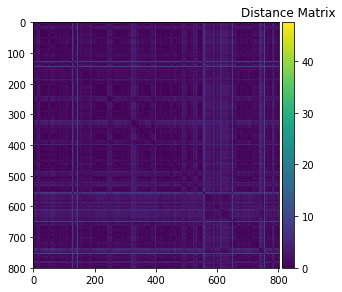

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


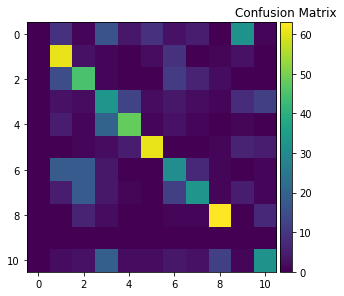

Recognition Rate: 54.285714285714285%
Total Components for Test: 72


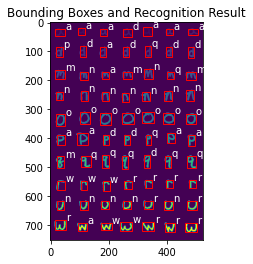

In [ ]:
test('test.bmp') #uses 3 nearest neighbors

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


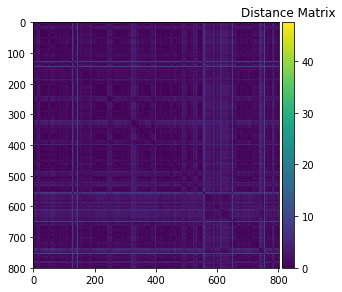

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


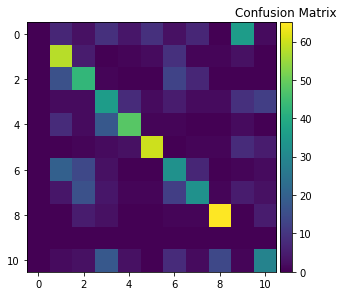

Recognition Rate: 50.0%
Total Components for Test: 72


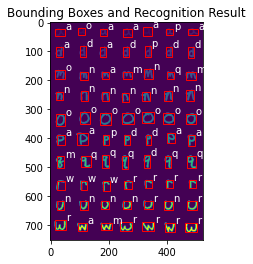

In [ ]:
test('test.bmp') # uses 5 neighbors

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


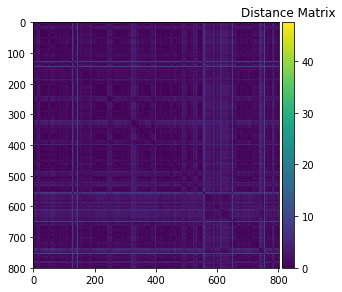

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


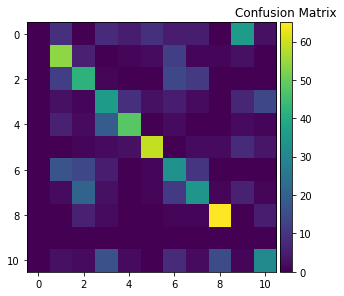

Recognition Rate: 57.142857142857146%
Total Components for Test: 72


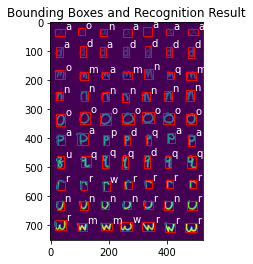

In [ ]:
test('test.bmp') # uses 7 neighbors

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


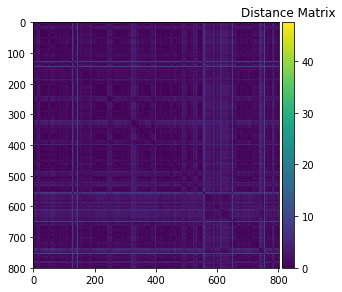

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


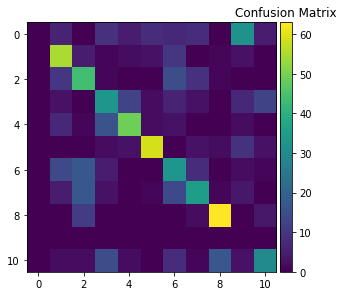

Recognition Rate: 54.285714285714285%
Total Components for Test: 72


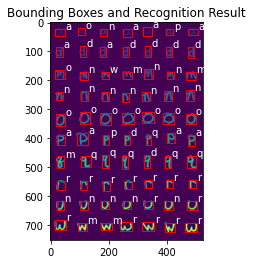

In [ ]:
test('test.bmp') # uses 11 neighbors

####Results

Four trials were performed with the k neighbor technique.

* 3 => 54.29%
* 5 => 50.0%
* 7 => 57.14%
* 11 => 54.29%

Three of these trials resulted in an improvement over the baseline rate, with the 7-neighbor approach resulting in the highest rate yet, with an recognition improvement by 11.10%.

###Results After Individual Enhancements

Three potential enhancements were examined here. The highest rate achieved by modifying the threshold was 54.29% using a threshold of 200. No higher rate was achieved using binary morphology on either a higher nor lower threshold. Using k-neighbor classification did bring a boost in recognition, specifically with 7 neighbors resulting in 57.14%.

###Combination of Enhancements

This last attempt will utilize all of the above mentioned enhancement possibilities. This includes a threshold of 200, a morphological open, and 7 neighbor classification.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage import io, exposure, morphology
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle

FeatureData = []
LabelData = []
Means = []
Stds = []
pkl_file = open('test_gt_py3.pkl', 'rb')
mydict = pickle.load(pkl_file)
pkl_file.close()
classes = mydict[b'classes']
locations = mydict[b'locations']
Chars = ['a', 'd', 'm', 'n', 'o', 'p', 'q', 'r', 'u', 'w']

def contains_groundtruth(minr, maxr, minc, maxc):
    global locations
    for i in range(len(locations)):
        loc = locations[i]
        if(loc[0] >= minc and loc[0] <= maxc and loc[1] >= minr and loc[1] <= maxr): return i
    return -1

def neighbor_select(D_ind_row, num, offset):
    global Chars
    global LabelData
    letters = [] # 2d array with char and number
    appearances = []
    for i in range(offset, offset+num):
        in_letter = LabelData[D_ind_row[i]].lower()
        letters.append(in_letter)
    for char in Chars:
        freq = letters.count(char)
        appearances.append(freq)
    ind = np.argmax(appearances)
    if(isinstance(ind, list)): ind = ind[0]
    return Chars[ind]


In [ ]:
def train(debug=False):
    global FeatureData
    global LabelData
    global Means
    global Stds
    total_boxes = []
    # The elements of this array contain all of the
    # bounding box corrdinates for each letter component
    for char in Chars:

        # each char training image is opened, binarized, and labeled
        char_img = io.imread(f'{char}.bmp')
        char_bin = (char_img<200).astype(np.double)
        char_open = morphology.area_opening(char_bin)
        char_lbl = label(char_open, background=0)
        # components are extracted
        regions = regionprops(char_lbl)
        letter_boxes = []
        for props in regions:
            # each bounding box is identified
            minr, minc, maxr, maxc = props.bbox
            reg_width = maxc-minc
            reg_height = maxr-minr
            # if the detected box has either width or height underneath
            # the size threshold of 10 pixels, it is ignored
            if(reg_width<=10 or reg_height<=10): continue
            # the box is above the threshold and its region is ready
            # to be processed
            letter_boxes.append([minc, maxc, minr, maxr])
            roi = char_bin[minr:maxr, minc:maxc]
            # computing the hu moments for this region
            m = moments(roi)
            cc = m[0,1] / m[0,0]
            cr = m[1,0] / m[0,0]
            mu = moments_central(roi, center=(cr, cc))
            nu = moments_normalized(mu)
            hu = moments_hu(nu)
            # adding hu moments and associated label data
            # their respective arrays
            FeatureData.append(hu)
            LabelData.append(char if char != 'u' else 'U')
        # each extracted box coordinates are added to the total
        total_boxes.append(letter_boxes)
    # feature data is being normalized
    Means = np.mean(FeatureData, axis=0)
    Stds = np.std(FeatureData, axis=0)
    for feature in FeatureData:
        for i in range(7):
            feature[i] = (feature[i]-Means[i])/Stds[i]
    # Distance Matrix computed and sorted
    DistMatrix = cdist(FeatureData, FeatureData)
    D_index = np.argsort(DistMatrix, axis=1)
    Ytrue = []
    Ypred = []
    for i in range(len(FeatureData)):
        Ytrue.append(LabelData[i])
        Ypred.append(neighbor_select(D_index[i], 7, 1))
    confM = confusion_matrix(Ytrue, Ypred)
    # Confusion Matrix computed

    if(debug is True):
    # generating recognition images
        running = 0
        for i in range(len(Chars)):
            # regenerates label images
            curr_char = Chars[i]
            char_img = io.imread(f'{curr_char}.bmp')
            char_bin = (char_img<th).astype(np.double)
            char_lbl = label(char_bin, background=0)
            # retrieves box coordinates
            letter_boxes = total_boxes[i]
            plt.imshow(char_bin)
            ax = plt.gca()
            for j in range(len(letter_boxes)):
                minc = letter_boxes[j][0]
                maxc = letter_boxes[j][1]
                minr = letter_boxes[j][2]
                maxr = letter_boxes[j][3]
                # adds rectangles based on box corrdinates
                ax.add_patch(Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, edgecolor='red', linewidth=1))
                # adds recognized letter to image
                ax.text(maxc+1, minr+1, Ypred[running+j], color='white')
            running += len(letter_boxes)
            ax.set_title('Bounding Boxes and Recognition Result')
            io.show()

    # displaying distance and confusion matrices
    io.imshow(DistMatrix)
    plt.title('Distance Matrix')
    io.show()
    io.imshow(confM)
    plt.title('Confusion Matrix')
    io.show()

In [ ]:
def test(path, debug=False):
    train(debug)
    global FeatureData
    global LabelData
    global Means
    global Stds
    global classes

    # processes image in the same way as in the training data
    img = io.imread(path)
    img_bin = (img<200).astype(np.double)
    img_open = morphology.area_opening(img_bin)
    img_lbl = label(img_open, background=0)
    total_components = np.amax(img_lbl)
    regions = regionprops(img_lbl)
    groundtruth_labels = []
    test_features = []
    test_labels = []
    letter_boxes = []
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        reg_width = maxc-minc
        reg_height = maxr-minr
        if(reg_width<=10 or reg_height<=10): continue
        # calls groundtruth detection code
        gt_index = contains_groundtruth(minr, maxr, minc, maxc)
        if(gt_index == -1): continue
        else: groundtruth_labels.append(classes[gt_index])
        # if index was found, groundtruth label is retrieved and logged
        letter_boxes.append([minc, maxc, minr, maxr])
        roi = img_bin[minr:maxr, minc:maxc]
        m = moments(roi)
        cc = m[0,1] / m[0,0]
        cr = m[1,0] / m[0,0]
        mu = moments_central(roi, center=(cr, cc))
        nu = moments_normalized(mu)
        hu = moments_hu(nu)
        test_features.append(hu)
    # new features are normalized
    for feature in test_features:
        for i in range(7):
            feature[i] = (feature[i]-Means[i])/Stds[i]
    # new distance matrix computed and used for recognition
    TestDistance = cdist(test_features, FeatureData)
    TD_index = np.argsort(TestDistance, axis=1)
    hits = 0
    misses = 0
    for i in range(len(test_features)):
        test_labels.append(neighbor_select(TD_index[i], 7, 0))
        # detects recognition hits and misses
        if(test_labels[i] == groundtruth_labels[i]): hits += 1
        else: misses += 1
    # recognition rate computed here
    hitRate = 100*hits/len(test_labels)
    print(f'Recognition Rate: {hitRate}%')
    # total components, including those excluded from analysis
    # are counted
    print(f'Total Components for Test: {total_components}')
    plt.imshow(img_lbl)
    ax = plt.gca()
    # recognition image generated
    for i in range(len(letter_boxes)):
        minc = letter_boxes[i][0]
        maxc = letter_boxes[i][1]
        minr = letter_boxes[i][2]
        maxr = letter_boxes[i][3]
        ax.add_patch(Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, edgecolor='red', linewidth=1))
        ax.text(maxc+1, minr+1, test_labels[i], color='white')
    ax.set_title('Bounding Boxes and Recognition Result')
    io.show()

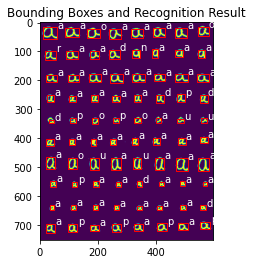

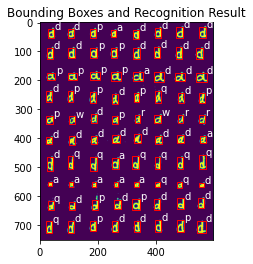

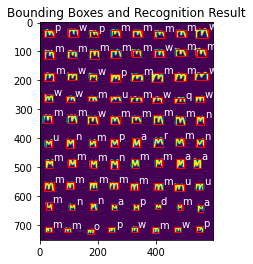

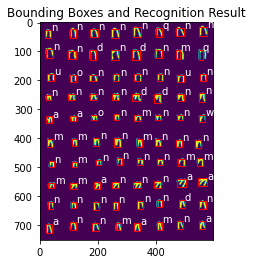

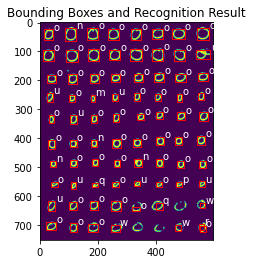

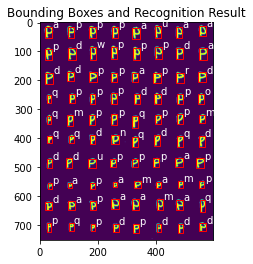

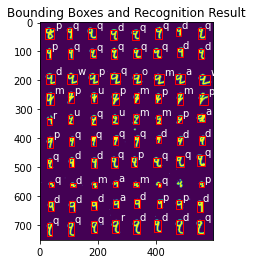

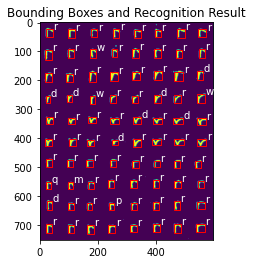

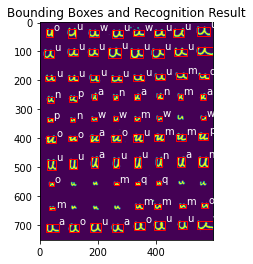

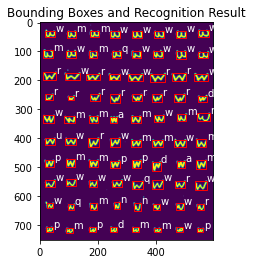

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


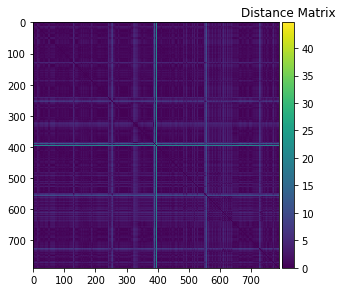

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


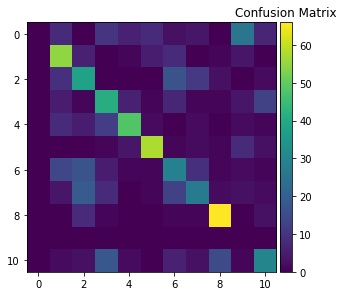

Recognition Rate: 51.42857142857143%
Total Components for Test: 70


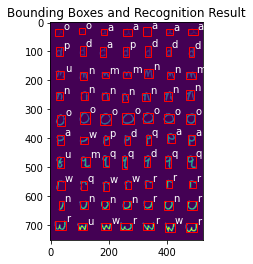

In [ ]:
test('test.bmp', debug=True)

###Conclusion

In a twist of fate combining all potential enhancements for the system resulted in the recognition rate remaining at 51.43%. While other complex enhancements are likely possible for this system, these were the only enhancements I had time to utilize and implement properly. That being said, the rate was indeed able to be improved by a sizeable amount from its original rate, even if the rate wasn't able to reach 60% or higher

##Final Code and Results

Below is the code used for achieving the highest possible recognition rate of 57.14% as well as the direct results from said code.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pickle

# important global structures
FeatureData = []
LabelData = []
Means = []
Stds = []
th = 235
Chars = ['a', 'd', 'm', 'n', 'o', 'p', 'q', 'r', 'u', 'w']
neighbors = 7

# importing from pkl file
pkl_file = open('test_gt_py3.pkl', 'rb')
mydict = pickle.load(pkl_file)
pkl_file.close()
classes = mydict[b'classes']
locations = mydict[b'locations']

# locates groundtruth from given set of box coordinates and returns index of location
def contains_groundtruth(minr, maxr, minc, maxc):
    global locations
    for i in range(len(locations)):
        loc = locations[i]
        if(loc[0] >= minc and loc[0] <= maxc and loc[1] >= minr and loc[1] <= maxr): return i
    return -1 # groundtruth unable to be found

# goes through row of sorted distance matrix, collects the frequency of each corresponding letter
# finds the one that appears most (or first if there is no one max), and returns it
def neighbor_select(D_ind_row, offset):
    global Chars
    global LabelData
    letters = []
    appearances = []
    for i in range(offset, offset+neighbors):
        in_letter = LabelData[D_ind_row[i]].lower()
        letters.append(in_letter)
    for char in Chars:
        freq = letters.count(char)
        appearances.append(freq)
    ind = np.argmax(appearances)
    if(isinstance(ind, list)): return Chars[ind[0]]
    else: return Chars[ind]

# training code, debug flag determines whether or not individual letter images are shown
def train(debug=False):
    global FeatureData
    global LabelData
    global Means
    global Stds
    total_boxes = []
    for char in Chars:

        # each char training image is opened, binarized, and labeled
        char_img = io.imread(f'{char}.bmp')
        char_bin = (char_img<th).astype(np.double)
        char_lbl = label(char_bin, background=0)
        # components are extracted
        regions = regionprops(char_lbl)
        letter_boxes = []
        for props in regions:
            # each bounding box is identified
            minr, minc, maxr, maxc = props.bbox
            reg_width = maxc-minc
            reg_height = maxr-minr
            # if the detected box has either width or height underneath
            # the size threshold of 10 pixels, it is ignored
            if(reg_width<=10 or reg_height<=10): continue
            # the box is above the threshold and its region is ready
            # to be processed
            letter_boxes.append([minc, maxc, minr, maxr])
            roi = char_bin[minr:maxr, minc:maxc]
            # computing the hu moments for this region
            m = moments(roi)
            cc = m[0,1] / m[0,0]
            cr = m[1,0] / m[0,0]
            mu = moments_central(roi, center=(cr, cc))
            nu = moments_normalized(mu)
            hu = moments_hu(nu)
            # adding hu moments and associated label data
            # their respective arrays
            FeatureData.append(hu)
            LabelData.append(char if char != 'u' else 'U')
        # each extracted box coordinates are added to the total
        total_boxes.append(letter_boxes)
    # feature data is being normalized
    Means = np.mean(FeatureData, axis=0)
    Stds = np.std(FeatureData, axis=0)
    for feature in FeatureData:
        for i in range(7):
            feature[i] = (feature[i]-Means[i])/Stds[i]
    # Distance Matrix computed and sorted
    DistMatrix = cdist(FeatureData, FeatureData)
    D_index = np.argsort(DistMatrix, axis=1)
    Ytrue = []
    Ypred = []
    for i in range(len(FeatureData)):
        Ytrue.append(LabelData[i])
        Ypred.append(neighbor_select(D_index[i], 1))
    confM = confusion_matrix(Ytrue, Ypred)
    # Confusion Matrix computed

    if(debug is True):
    # generating recognition images
        running = 0
        for i in range(len(Chars)):
            # regenerates label images
            curr_char = Chars[i]
            char_img = io.imread(f'{curr_char}.bmp')
            char_bin = (char_img<th).astype(np.double)
            char_lbl = label(char_bin, background=0)
            # retrieves box coordinates
            letter_boxes = total_boxes[i]
            plt.imshow(char_bin)
            ax = plt.gca()
            for j in range(len(letter_boxes)):
                minc = letter_boxes[j][0]
                maxc = letter_boxes[j][1]
                minr = letter_boxes[j][2]
                maxr = letter_boxes[j][3]
                # adds rectangles based on box corrdinates
                ax.add_patch(Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, edgecolor='red', linewidth=1))
                # adds recognized letter to image
                ax.text(maxc+1, minr+1, Ypred[running+j], color='white')
            running += len(letter_boxes)
            ax.set_title('Bounding Boxes and Recognition Result')
            io.show()

    # displaying distance and confusion matrices
    io.imshow(DistMatrix)
    plt.title('Distance Matrix')
    io.show()
    io.imshow(confM)
    plt.title('Confusion Matrix')
    io.show()

# testing code, debug flag determines behavior in training code
def test(path, debug=False):
    train(debug)
    global FeatureData
    global LabelData
    global Means
    global Stds
    global classes

    # processes image in the same way as in the training data
    img = io.imread(path)
    img_bin = (img<th).astype(np.double)
    img_lbl = label(img_bin, background=0)
    total_components = np.amax(img_lbl)
    regions = regionprops(img_lbl)
    groundtruth_labels = []
    test_features = []
    test_labels = []
    letter_boxes = []
    for props in regions:
        minr, minc, maxr, maxc = props.bbox
        reg_width = maxc-minc
        reg_height = maxr-minr
        if(reg_width<=10 or reg_height<=10): continue
        # calls groundtruth detection code
        gt_index = contains_groundtruth(minr, maxr, minc, maxc)
        if(gt_index == -1): continue
        else: groundtruth_labels.append(classes[gt_index])
        # if index was found, groundtruth label is retrieved and logged
        letter_boxes.append([minc, maxc, minr, maxr])
        roi = img_bin[minr:maxr, minc:maxc]
        m = moments(roi)
        cc = m[0,1] / m[0,0]
        cr = m[1,0] / m[0,0]
        mu = moments_central(roi, center=(cr, cc))
        nu = moments_normalized(mu)
        hu = moments_hu(nu)
        test_features.append(hu)
    # new features are normalized
    for feature in test_features:
        for i in range(7):
            feature[i] = (feature[i]-Means[i])/Stds[i]
    # new distance matrix computed and used for recognition
    TestDistance = cdist(test_features, FeatureData)
    TD_index = np.argsort(TestDistance, axis=1)
    hits = 0
    misses = 0
    for i in range(len(test_features)):
        test_labels.append(neighbor_select(TD_index[i], 0))
        # detects recognition hits and misses
        if(test_labels[i] == groundtruth_labels[i]): hits += 1
        else: misses += 1
    # recognition rate computed here
    hitRate = 100*hits/len(test_labels)
    print(f'Recognition Rate: {hitRate}%')
    # total components, including those excluded from analysis
    # are counted
    print(f'Total Components for Test: {total_components}')
    plt.imshow(img_lbl)
    ax = plt.gca()
    # recognition image generated
    for i in range(len(letter_boxes)):
        minc = letter_boxes[i][0]
        maxc = letter_boxes[i][1]
        minr = letter_boxes[i][2]
        maxr = letter_boxes[i][3]
        ax.add_patch(Rectangle((minc, minr), maxc-minc, maxr-minr, fill=False, edgecolor='red', linewidth=1))
        ax.text(maxc+1, minr+1, test_labels[i], color='white')
    ax.set_title('Bounding Boxes and Recognition Result')
    io.show()

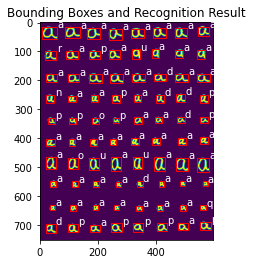

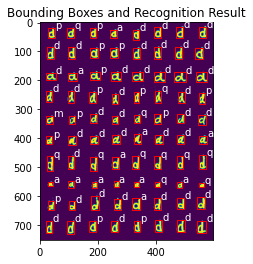

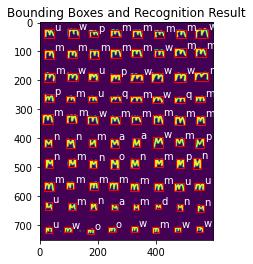

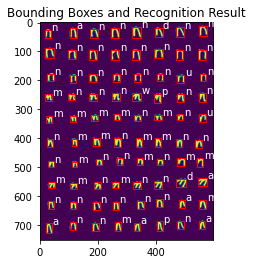

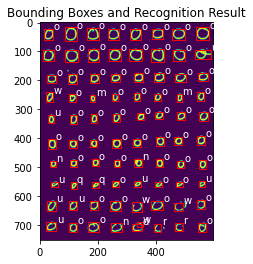

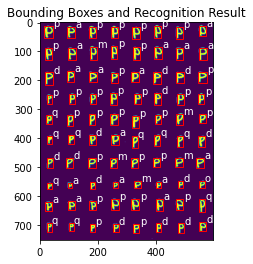

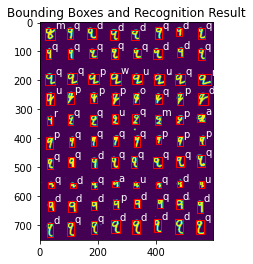

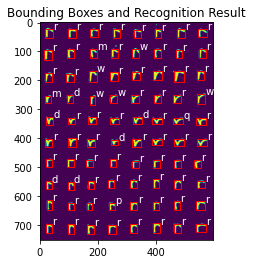

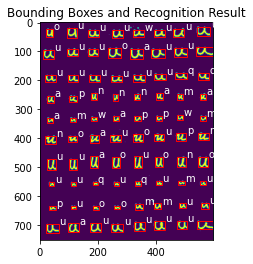

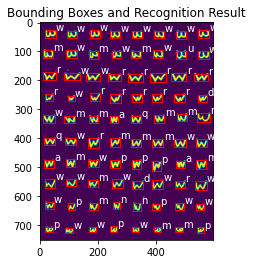

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


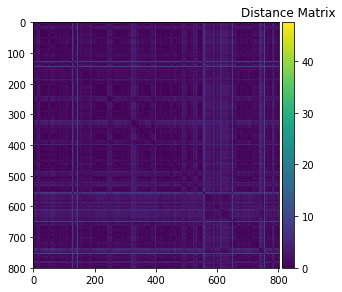

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


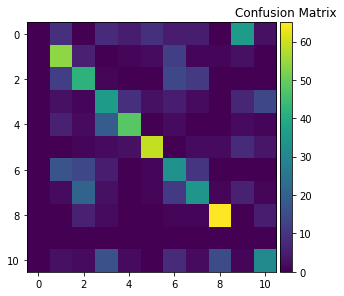

Recognition Rate: 57.142857142857146%
Total Components for Test: 72


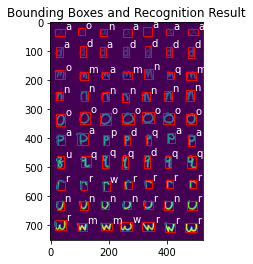

In [ ]:
test('test.bmp', debug=True)